In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

import h5py
import numpy as np

sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/fcstpp/')

import data_utils as du
import graph_utils as gu
from fcstpp import utils as fu

from namelist import * 

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# Data

In [5]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

In [6]:
with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]

## Datetime info

In [7]:
mon_rain = np.array([9, 10, 11, 0, 1, 2])
mon_dry = np.array([3, 4, 5, 6, 7, 8])

base = datetime(2017, 1, 1)
date_list = [base + timedelta(days=x) for x in range(365+365+365)]

rain_inds = np.zeros((len(date_list),), dtype=bool)
dry_inds = np.zeros((len(date_list),), dtype=bool)

mon_inds = []
for d, date in enumerate(date_list):
    
    mon_inds.append(date.month-1)
    if date.month-1 in mon_dry:
        dry_inds[d] = True
    else:
        rain_inds[d] = True
        
mon_inds = np.array(mon_inds)

fcst_leads = np.arange(3, 72*3+3, 3, dtype=np.float)

## CRPS results

In [8]:
from scipy.stats import wilcoxon

def wilcoxon_by_leads(FCST1, FCST2):
    N, L = FCST1.shape
    w_stat = np.empty((L,))
    p_vals = np.empty((L,))
    
    series1 = FCST1
    series2 = FCST2
    
    for i in range(L):
        w_, p_ = wilcoxon(series1[:, i], series2[:, i],)
        w_stat[i] = w_
        p_vals[i] = p_
    return w_stat, p_vals

def boost_mean_std(data):
    temp = fu.score_bootstrap_1d(data, bootstrap_n=100)
    mean_ = np.mean(temp, axis=-1)
    p95_ = np.quantile(temp-mean_[..., None], 0.95, axis=-1)
    return mean_, p95_

In [9]:
def leads_to_days(data):
    day_ind = [0, 6, 14, 22, 30, 38, 46, 54]
    n_day, _, n_stn = data.shape
    out = np.empty((n_day, 7, n_stn))
    
    for i in range(7):
        out[:, i, :] = np.mean(data[:, day_ind[i]:day_ind[i+1], :], axis=1)
        
    return out

In [10]:
# with h5py.File(save_dir+'CLIM_CRPS_BCH_2017.hdf', 'r') as h5io:
#     CLIM_D_17 = leads_to_days(h5io['CRPS'][...])
# with h5py.File(save_dir+'CLIM_CRPS_BCH_2018.hdf', 'r') as h5io:
#     CLIM_D_18 = leads_to_days(h5io['CRPS'][...])
# with h5py.File(save_dir+'CLIM_CRPS_BCH_2019.hdf', 'r') as h5io:
#     CLIM_D_19 = leads_to_days(h5io['CRPS'][...])

# with h5py.File(save_dir+'BASE_CNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     BCNN_D_17 = leads_to_days(h5io['CRPS'][...])
# with h5py.File(save_dir+'BASE_CNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     BCNN_D_18 = leads_to_days(h5io['CRPS'][...])
# with h5py.File(save_dir+'BASE_CNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     BCNN_D_19 = leads_to_days(h5io['CRPS'][...])

# with h5py.File(save_dir+'SL_CNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     SCNN_D_17 = leads_to_days(h5io['CRPS'][...])
# with h5py.File(save_dir+'SL_CNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     SCNN_D_18 = leads_to_days(h5io['CRPS'][...])
# with h5py.File(save_dir+'SL_CNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     SCNN_D_19 = leads_to_days(h5io['CRPS'][...])
    
# with h5py.File(save_dir+'BCSD_BCNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     BCSD_BCNN_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BCSD_BCNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     BCSD_BCNN_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BCSD_BCNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     BCSD_BCNN_19 = h5io['CRPS'][...]
    
# with h5py.File(save_dir+'BCSD_SCNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     BCSD_SCNN_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BCSD_SCNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     BCSD_SCNN_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BCSD_SCNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     BCSD_SCNN_19 = h5io['CRPS'][...]
    
# with h5py.File(save_dir+'DCNN_BCNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     DCNN_BCNN_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'DCNN_BCNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     DCNN_BCNN_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'DCNN_BCNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     DCNN_BCNN_19 = h5io['CRPS'][...]
    
# with h5py.File(save_dir+'DCNN_SCNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     DCNN_SCNN_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'DCNN_SCNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     DCNN_SCNN_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'DCNN_SCNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     DCNN_SCNN_19 = h5io['CRPS'][...]
    
# CLIM_D = np.concatenate((CLIM_D_17, CLIM_D_18, CLIM_D_19), axis=0)

# BCNN_D = np.concatenate((BCNN_D_17, BCNN_D_18, BCNN_D_19), axis=0)
# SCNN_D = np.concatenate((SCNN_D_17, SCNN_D_18, SCNN_D_19), axis=0)

# BCSD_BCNN = np.concatenate((BCSD_BCNN_17, BCSD_BCNN_18, BCSD_BCNN_19), axis=0)
# BCSD_SCNN = np.concatenate((BCSD_SCNN_17, BCSD_SCNN_18, BCSD_SCNN_19), axis=0)

# DCNN_BCNN = np.concatenate((DCNN_BCNN_17, DCNN_BCNN_18, DCNN_BCNN_19), axis=0)
# DCNN_SCNN = np.concatenate((DCNN_SCNN_17, DCNN_SCNN_18, DCNN_SCNN_19), axis=0)

# CLIM_D_rain = np.transpose(CLIM_D[rain_inds, :], (0, 2, 1))
# BCNN_D_rain = np.transpose(BCNN_D[rain_inds, :], (0, 2, 1))
# SCNN_D_rain = np.transpose(SCNN_D[rain_inds, :], (0, 2, 1))
# BCSD_BCNN_rain = np.transpose(BCSD_BCNN[rain_inds, :], (0, 2, 1))
# BCSD_SCNN_rain = np.transpose(BCSD_SCNN[rain_inds, :], (0, 2, 1))
# DCNN_BCNN_rain = np.transpose(DCNN_BCNN[rain_inds, :], (0, 2, 1))
# DCNN_SCNN_rain = np.transpose(DCNN_SCNN[rain_inds, :], (0, 2, 1))

# CLIM_D_dry = np.transpose(CLIM_D[dry_inds, :], (0, 2, 1))
# BCNN_D_dry = np.transpose(BCNN_D[dry_inds, :], (0, 2, 1))
# SCNN_D_dry = np.transpose(SCNN_D[dry_inds, :], (0, 2, 1))
# BCSD_BCNN_dry = np.transpose(BCSD_BCNN[dry_inds, :], (0, 2, 1))
# BCSD_SCNN_dry = np.transpose(BCSD_SCNN[dry_inds, :], (0, 2, 1))
# DCNN_BCNN_dry = np.transpose(DCNN_BCNN[dry_inds, :], (0, 2, 1))
# DCNN_SCNN_dry = np.transpose(DCNN_SCNN[dry_inds, :], (0, 2, 1))

# CLIM_D_rain_mean = np.nanmean(CLIM_D_rain, axis=(0, 1))
# CLIM_D_dry_mean = np.nanmean(CLIM_D_dry, axis=(0, 1))

# BCNN_D_rain_mean, BCNN_D_rain_std = boost_mean_std(BCNN_D_rain)
# SCNN_D_rain_mean, SCNN_D_rain_std = boost_mean_std(SCNN_D_rain)
# BCNN_D_dry_mean, BCNN_D_dry_std = boost_mean_std(BCNN_D_dry)
# SCNN_D_dry_mean, SCNN_D_dry_std = boost_mean_std(SCNN_D_dry)

# BCSD_BCNN_rain_mean, BCSD_BCNN_rain_std = boost_mean_std(BCSD_BCNN_rain)
# BCSD_SCNN_rain_mean, BCSD_SCNN_rain_std = boost_mean_std(BCSD_SCNN_rain)
# BCSD_BCNN_dry_mean, BCSD_BCNN_dry_std = boost_mean_std(BCSD_BCNN_dry)
# BCSD_SCNN_dry_mean, BCSD_SCNN_dry_std = boost_mean_std(BCSD_SCNN_dry)

# DCNN_BCNN_rain_mean, DCNN_BCNN_rain_std = boost_mean_std(DCNN_BCNN_rain)
# DCNN_SCNN_rain_mean, DCNN_SCNN_rain_std = boost_mean_std(DCNN_SCNN_rain)
# DCNN_BCNN_dry_mean, DCNN_BCNN_dry_std = boost_mean_std(DCNN_BCNN_dry)
# DCNN_SCNN_dry_mean, DCNN_SCNN_dry_std = boost_mean_std(DCNN_SCNN_dry)

# D_MEAN = {}

# D_MEAN['bcnn_rain'] = 1-BCNN_D_rain_mean/CLIM_D_rain_mean
# D_MEAN['scnn_rain'] = 1-SCNN_D_rain_mean/CLIM_D_rain_mean
# D_MEAN['bcnn_dry'] = 1-BCNN_D_dry_mean/CLIM_D_dry_mean
# D_MEAN['scnn_dry'] = 1-SCNN_D_dry_mean/CLIM_D_dry_mean

# D_MEAN['bcsd_bcnn_rain'] = 1-BCSD_BCNN_rain_mean/CLIM_D_rain_mean
# D_MEAN['bcsd_scnn_rain'] = 1-BCSD_SCNN_rain_mean/CLIM_D_rain_mean
# D_MEAN['bcsd_bcnn_dry'] = 1-BCSD_BCNN_dry_mean/CLIM_D_dry_mean
# D_MEAN['bcsd_scnn_dry'] = 1-BCSD_SCNN_dry_mean/CLIM_D_dry_mean

# D_MEAN['dcnn_bcnn_rain'] = 1-DCNN_BCNN_rain_mean/CLIM_D_rain_mean
# D_MEAN['dcnn_scnn_rain'] = 1-DCNN_SCNN_rain_mean/CLIM_D_rain_mean
# D_MEAN['dcnn_bcnn_dry'] = 1-DCNN_BCNN_dry_mean/CLIM_D_dry_mean
# D_MEAN['dcnn_scnn_dry'] = 1-DCNN_SCNN_dry_mean/CLIM_D_dry_mean

# D_STD = {}

# D_STD['bcnn_rain'] = BCNN_D_rain_std
# D_STD['scnn_rain'] = SCNN_D_rain_std
# D_STD['bcnn_dry'] = BCNN_D_dry_std
# D_STD['scnn_dry'] = SCNN_D_dry_std

# D_STD['bcsd_bcnn_rain'] = BCSD_BCNN_rain_std
# D_STD['bcsd_scnn_rain'] = BCSD_SCNN_rain_std
# D_STD['bcsd_bcnn_dry'] = BCSD_BCNN_dry_std
# D_STD['bcsd_scnn_dry'] = BCSD_SCNN_dry_std

# D_STD['dcnn_bcnn_rain'] = DCNN_BCNN_rain_std
# D_STD['dcnn_scnn_rain'] = DCNN_SCNN_rain_std
# D_STD['dcnn_bcnn_dry'] = DCNN_BCNN_dry_std
# D_STD['dcnn_scnn_dry'] = DCNN_SCNN_dry_std

# BCNN_D_rain_ave = np.nanmean(BCNN_D[rain_inds, ...], axis=(2,))
# SCNN_D_rain_ave = np.nanmean(SCNN_D[rain_inds, ...], axis=(2,))
# BCNN_D_dry_ave = np.nanmean(BCNN_D[dry_inds, ...], axis=(2,))
# SCNN_D_dry_ave = np.nanmean(SCNN_D[dry_inds, ...], axis=(2,))

# BCSD_BCNN_rain_ave = np.nanmean(BCSD_BCNN[rain_inds, ...], axis=(2,))
# BCSD_SCNN_rain_ave = np.nanmean(BCSD_SCNN[rain_inds, ...], axis=(2,))
# BCSD_BCNN_dry_ave = np.nanmean(BCSD_BCNN[dry_inds, ...], axis=(2,))
# BCSD_SCNN_dry_ave = np.nanmean(BCSD_SCNN[dry_inds, ...], axis=(2,))

# DCNN_BCNN_rain_ave = np.nanmean(DCNN_BCNN[rain_inds, ...], axis=(2,))
# DCNN_SCNN_rain_ave = np.nanmean(DCNN_SCNN[rain_inds, ...], axis=(2,))
# DCNN_BCNN_dry_ave = np.nanmean(DCNN_BCNN[dry_inds, ...], axis=(2,))
# DCNN_SCNN_dry_ave = np.nanmean(DCNN_SCNN[dry_inds, ...], axis=(2,))

# D_wilcox = {}
# w_stat, p_vals = wilcoxon_by_leads(BCSD_BCNN_rain_ave, BCNN_D_rain_ave)
# D_wilcox['BCSD_BCNN_rain'] = p_vals
# w_stat, p_vals = wilcoxon_by_leads(BCSD_SCNN_rain_ave, SCNN_D_rain_ave)
# D_wilcox['BCSD_SCNN_rain'] = p_vals
# w_stat, p_vals = wilcoxon_by_leads(DCNN_BCNN_rain_ave, BCNN_D_rain_ave)
# D_wilcox['DCNN_BCNN_rain'] = p_vals
# w_stat, p_vals = wilcoxon_by_leads(DCNN_SCNN_rain_ave, SCNN_D_rain_ave)
# D_wilcox['DCNN_SCNN_rain'] = p_vals

# w_stat, p_vals = wilcoxon_by_leads(BCSD_BCNN_dry_ave, BCNN_D_dry_ave)
# D_wilcox['BCSD_BCNN_dry'] = p_vals
# w_stat, p_vals = wilcoxon_by_leads(BCSD_SCNN_dry_ave, SCNN_D_dry_ave)
# D_wilcox['BCSD_SCNN_dry'] = p_vals
# w_stat, p_vals = wilcoxon_by_leads(DCNN_BCNN_dry_ave, BCNN_D_dry_ave)
# D_wilcox['DCNN_BCNN_dry'] = p_vals
# w_stat, p_vals = wilcoxon_by_leads(DCNN_SCNN_dry_ave, SCNN_D_dry_ave)
# D_wilcox['DCNN_SCNN_dry'] = p_vals

# np.save(save_dir+'D_BCH_rain_dry.npy', D_MEAN)
# np.save(save_dir+'D_BCH_rain_dry_std.npy', D_STD)
# np.save(save_dir+'D_BCH_wilcox.npy', D_wilcox)

In [11]:
CRPS_MEAN = np.load(save_dir+'D_BCH_rain_dry.npy', allow_pickle=True)[()]
CRPS_STD = np.load(save_dir+'D_BCH_rain_dry_std.npy', allow_pickle=True)[()]
CRPS_wilcox = np.load(save_dir+'D_BCH_wilcox.npy', allow_pickle=True)[()]

# Figure

In [12]:
edge_bc = [-141, -113.25, 48.25, 60]

def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

r_bc = aspc_cal(edge_bc)

In [13]:
cmap_pct, A = gu.precip_cmap()

In [14]:
gray = [0.5, 0.5, 0.5]

KW = {}
KW['bcsd_scnn'] = {'linestyle': '-', 'color': red, 'ecolor':red, 'linewidth':2.5, 'elinewidth':2.5, 'barsabove':False}
KW['dcnn_scnn'] = {'linestyle': '-', 'color': blue, 'ecolor':blue, 'linewidth':2.5, 'elinewidth':2.5, 'barsabove':False}

kw_lines = {}
kw_lines['bcsd_scnn'] = {'linestyle': '-', 'color': red, 'linewidth':2.5}
kw_lines['dcnn_scnn'] = {'linestyle': '-', 'color': blue, 'linewidth':2.5}

kw_bar = {'bottom':0.0, 'width': 0.4, 'color': '0.75', 'edgecolor': 'k', 'linestyle': '-', 'linewidth': 0}
#kw_step = {'color': 'k', 'linestyle': '-', 'linewidth': 1.5, 'where':'post'}

In [15]:
fontsize = 14

## Line graph

In [16]:
cates = ['rain', 'dry']
method_crps = ['scnn', 'bcsd_scnn', 'dcnn_scnn']
fake_x = np.arange(7)

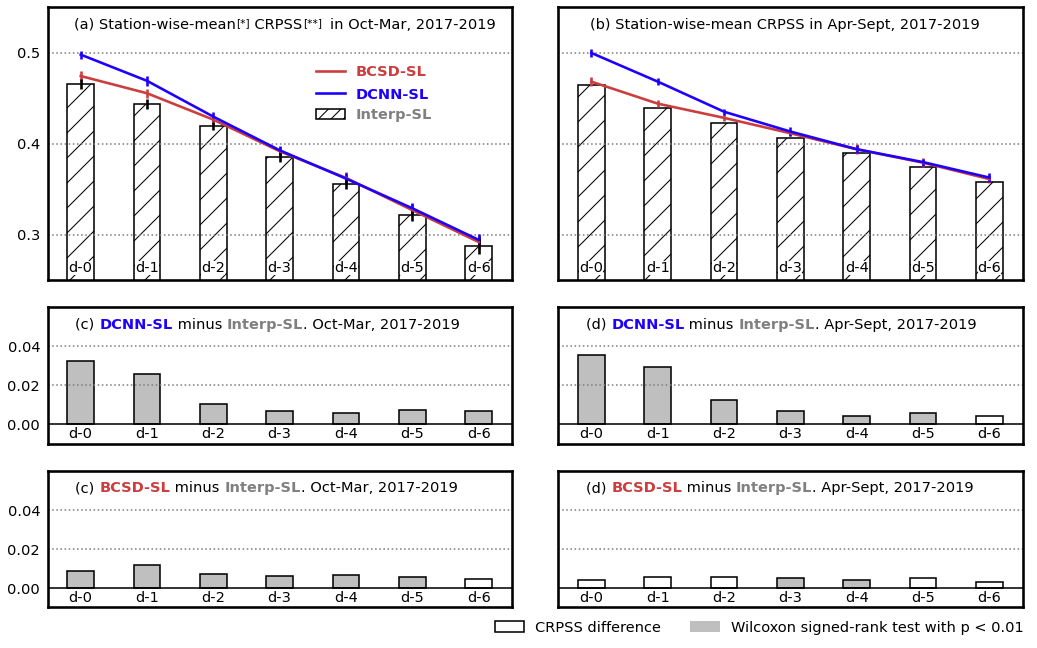

In [17]:
fig = plt.figure(figsize=(13, 8), dpi=dpi_)

gs = gridspec.GridSpec(5, 3, height_ratios=[1, 0.1, 0.5, 0.1, 0.5], width_ratios=[1, 0.1, 1])

ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[2, 0])
ax13 = plt.subplot(gs[4, 0])

ax21 = plt.subplot(gs[0, 2])
ax22 = plt.subplot(gs[2, 2])
ax23 = plt.subplot(gs[4, 2])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

handles = []

AX_all = [ax11, ax12, ax13, ax21, ax22, ax23,]
AX_crps = [ax11, ax21]

AX_diff_sub1 = [ax12, ax22]
AX_diff_sub2 = [ax13, ax23]

ax_t1 = fig.add_axes([0, 0.95, (2/4.1), 0.031875])
ax_t1.set_axis_off()
handles.append(ax_t1.text(0.5, 1, '(a) Station-wise-mean    CRPSS      in Oct-Mar, 2017-2019', ha='center', va='top', 
               fontsize=fontsize, transform=ax_t1.transAxes))

handles.append(ax_t1.text(0.368+0.0275, 0.999, '[*]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))
handles.append(ax_t1.text(0.510+0.0275, 0.999, '[**]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))

ax_t2 = fig.add_axes([2.1/4.1, 0.95, (2/4.1), 0.031875])
ax_t2.set_axis_off()
handles.append(ax_t2.text(0.5, 1, '(b) Station-wise-mean CRPSS in Apr-Sept, 2017-2019', ha='center', va='top', 
               fontsize=fontsize, transform=ax_t2.transAxes))

x_start2, y_start2 = 0.06, 0.925

fontsize_list = [fontsize,]*5
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']

handles += gu.string_partial_format(fig, ax12, x_start2, y_start2, 'left', 'top', 
                                    ['(c) ', 'DCNN-SL', ' minus ', 'Interp-SL', '. Oct-Mar, 2017-2019'], 
                                    ['k', blue, 'k', gray, 'k'], fontsize_list, fontweight_list)

handles += gu.string_partial_format(fig, ax22, x_start2, y_start2, 'left', 'top', 
                                    ['(d) ', 'DCNN-SL', ' minus ', 'Interp-SL', '. Apr-Sept, 2017-2019'], 
                                    ['k', blue, 'k', gray, 'k'], fontsize_list, fontweight_list)

handles += gu.string_partial_format(fig, ax13, x_start2, y_start2, 'left', 'top', 
                                    ['(c) ', 'BCSD-SL', ' minus ', 'Interp-SL', '. Oct-Mar, 2017-2019'], 
                                    ['k', red, 'k', gray, 'k'], fontsize_list, fontweight_list)

handles += gu.string_partial_format(fig, ax23, x_start2, y_start2, 'left', 'top', 
                                    ['(d) ', 'BCSD-SL', ' minus ', 'Interp-SL', '. Apr-Sept, 2017-2019'], 
                                    ['k', red, 'k', gray, 'k'], fontsize_list, fontweight_list)

for ax in AX_all:
    ax = gu.ax_decorate_box(ax)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.set_xlim([-0.5, 6.5])
    ax.set_xticks(np.arange(7))
    ax.axhline(0, xmin=0, xmax=1.0, linewidth=1.5, linestyle='-', color='k', zorder=3)
    
    for d in range(1, 8):
        handles.append(ax.text(d/7.0-1/14, 0.02, 'd-{}'.format(int(d-1)), ha='center', va='bottom', 
                       fontsize=fontsize, transform=ax.transAxes, zorder=6))

for i, ax in enumerate(AX_crps):
    ax.set_ylim([0.25, 0.55])
    ax.set_yticks([0.3, 0.4, 0.5,])
    if i > 1:
        for y in np.arange(0.3, 0.7, 0.1):
            if np.abs(y-0)>0.01:
                ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5', zorder=2)
    else:
        for y in np.arange(0.3, 0.6, 0.1):
            if np.abs(y-0)>0.01:
                ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5', zorder=2)
                
for ax in AX_diff_sub1:
    ax.set_ylim([-0.01, 0.06])
    ax.set_yticks([0.0, 0.02, 0.04,])
    for y in np.arange(0.02, 0.06, 0.02):
        ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5')

for ax in AX_diff_sub2:
    ax.set_ylim([-0.01, 0.06])
    ax.set_yticks([0.0, 0.02, 0.04,])
    for y in np.arange(0.02, 0.06, 0.02):
        ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5')
                
ax11.tick_params(labelleft=True)
ax12.tick_params(labelleft=True)
ax13.tick_params(labelleft=True)

for i, key in enumerate(['bcsd_scnn', 'dcnn_scnn']):
    AX_crps[0].errorbar(fake_x, CRPS_MEAN['{}_rain'.format(key)], yerr=CRPS_STD['{}_rain'.format(key)], **KW[key], zorder=4)
    AX_crps[1].errorbar(fake_x, CRPS_MEAN['{}_dry'.format(key)], yerr=CRPS_STD['{}_dry'.format(key)], **KW[key], zorder=4)

AX_crps[0].errorbar(fake_x, CRPS_MEAN['scnn_rain'], yerr=CRPS_STD['scnn_rain'], color='k', linewidth=2.5, linestyle='none', zorder=4)
AX_crps[0].bar(fake_x, CRPS_MEAN['scnn_rain'.format(key)], width=0.4, linewidth=1.5, edgecolor='k', facecolor='w', hatch='/')
AX_crps[1].bar(fake_x, CRPS_MEAN['scnn_dry'.format(key)] , width=0.4, linewidth=1.5, edgecolor='k', facecolor='w', hatch='/')

for i, key in enumerate(['rain', 'dry']):
    diff_ = CRPS_MEAN['dcnn_scnn_{}'.format(key)]-CRPS_MEAN['scnn_{}'.format(key)]
    diff_sig = np.copy(diff_)
    diff_no = np.copy(diff_)
    diff_sig[CRPS_wilcox['DCNN_SCNN_{}'.format(key)] > 0.01] = np.nan
    diff_no[CRPS_wilcox['DCNN_SCNN_{}'.format(key)] <= 0.01] = np.nan
    AX_diff_sub1[i].bar(fake_x, diff_sig, width=0.4, color='0.75', edgecolor='k', linestyle='-', linewidth=1.5, zorder=2)
    AX_diff_sub1[i].bar(fake_x, diff_no, width=0.4, color='w', edgecolor='k', linestyle='-', linewidth=1.5, zorder=2)
    
    diff_ = CRPS_MEAN['bcsd_scnn_{}'.format(key)]-CRPS_MEAN['scnn_{}'.format(key)]
    diff_sig = np.copy(diff_)
    diff_no = np.copy(diff_)
    diff_sig[CRPS_wilcox['BCSD_SCNN_{}'.format(key)] > 0.01] = np.nan
    diff_no[CRPS_wilcox['BCSD_SCNN_{}'.format(key)] <= 0.01] = np.nan
    AX_diff_sub2[i].bar(fake_x, diff_sig, width=0.4, color='0.75', edgecolor='k', linestyle='-', linewidth=1.5, zorder=2)
    AX_diff_sub2[i].bar(fake_x, diff_no, width=0.4, color='w', edgecolor='k', linestyle='-', linewidth=1.5, zorder=2)

label_ = [' ', ' ']

handle_lines = []
handle_lines.append(mlines.Line2D([], [], label=label_[0], **kw_lines['bcsd_scnn']))
handle_lines.append(mlines.Line2D([], [], label=label_[1], **kw_lines['dcnn_scnn']))
handle_lines.append(patches.Patch(facecolor='none', edgecolor='k', linewidth=1.5, hatch='//', label=' '))

ax_lg1 = fig.add_axes([0.25, 0.775, 0.085, 0.15])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=handle_lines, bbox_to_anchor=(1, 1), ncol=1, loc=0, prop={'size':fontsize}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

ax11.text(0.6625, 0.7625, 'BCSD-SL', ha='left', va='center', fontsize=fontsize, fontweight='bold', 
            color=KW['bcsd_scnn']['color'], transform=ax11.transAxes)

ax11.text(0.6625, 0.6775, 'DCNN-SL', ha='left', va='center', fontsize=fontsize, fontweight='bold', 
            color=KW['dcnn_scnn']['color'], transform=ax11.transAxes)

ax11.text(0.6625, 0.6075, 'Interp-SL', ha='left', va='center', fontsize=fontsize, fontweight='bold', 
            color=gray, transform=ax11.transAxes)

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor='none', edgecolor='k', linewidth=1.5,
                                    label='CRPSS difference'))
handle_legneds.append(patches.Patch(facecolor=kw_bar['color'], edgecolor='none', 
                                    label='Wilcoxon signed-rank test with p < 0.01'))

ax_lg2 = fig.add_axes([0.445, -0.05, 0.55, 0.03/1.2/8*10.2])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend(handles=handle_legneds, bbox_to_anchor=(0.0, 0.5), ncol=2, loc=6, prop={'size':fontsize}, fancybox=False);
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)

for handle in handles:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))
    
if need_publish:
    # Save figure
    fig.savefig(fig_dir+'DSCAL_BCH_CRPS.png', format='png', **fig_keys)